## Model interpretation using SHAP for linear regression model predicting 2 meter temperature with sea surface temperature

The notebook shows how to apply the SHAP explainability method on a linear regression model trained to predict 2m air temperature from the [pred_temperature_ridge.ipynb](pred_temperature_ridge.ipynb) workflow. For more information on SHAP, you can reference the [documentation](https://shap.readthedocs.io/en/latest/) and this [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf). To do this we use [DIANNA](https://dianna.readthedocs.io/en/latest/), which is Python package which wraps XAI methods into a simple to run, uniform interface. Therefore, it should be possible to change the method applied easily if required.  

#### Values of Kernel SHAP method:
Kernel SHAP (SHapley Additive exPlanations) values are a unified measure of feature importance that allocates the contribution of each feature to the prediction for a specific instance. 

In the context of a regression problem, the interpretation of Kernel SHAP values is as follows:

- **Magnitude**: The magnitude of a SHAP value for a feature indicates the degree to which that feature affects the prediction. A larger absolute SHAP value means that the feature has a stronger impact on the output.
- **Sign**: The sign of a SHAP value indicates the direction of the effect. A positive SHAP value for a feature indicates that the presence of that feature increases the model's output, while a negative SHAP value indicates that the presence of that feature decreases the model's output.
- **Zero**: A SHAP value of zero for a feature indicates that the feature did not contribute to the prediction for that specific instance.

It's important to note that SHAP values are instance-specific. 

This notebook inludes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-test split (70%/30%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Load ONNX model
- Run Dianna on a data instance & interpret results

### 0 - Load Libraries

In [85]:
import lilio
import urllib
import xarray as xr
import dianna
import numpy as np
import pandas as pd

from numba.core.errors import NumbaDeprecationWarning
import warnings
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

### 1 - Define a calendar with `lilio`

Specify a time range for precursor and target intervals. 

In this example, we are creating a calendar with an anchor date of 8th January, a target of 30 days and 8 precursor intervals of 1 month each. 

In [86]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

### 2 - Load datasets

Load Sea Surface Temperature (SST) and (clustered) 2m air temperature data (T2M). Here we use data from 1959-2021 (63 years total). 

In [87]:
def load_data(url, field, var):
    '''Download a netCDF file from a URL and open a variable as xr.DataArray.'''
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataarray = dataset[var]
    return dataarray 

In [88]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

In [89]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m").sel(cluster=3)

### 3 - Map the calendar to the data

After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

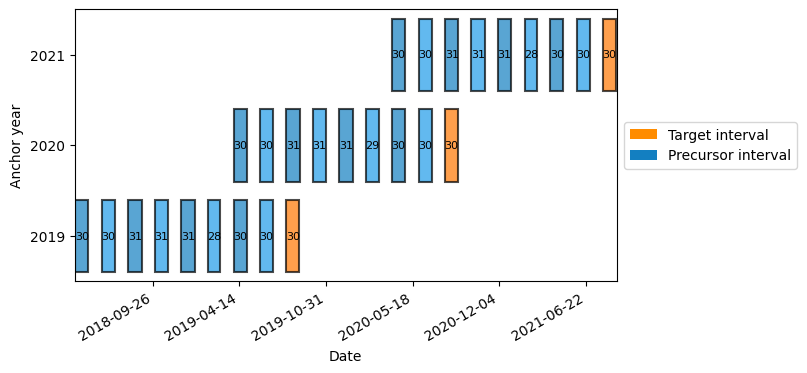

In [90]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

### 4 - Train-test split based on the anchor years (70%/30% split)

To fit RGDR to the model, we need to split the data into a training and testing dataset. This can be refered to as the "outer cross-validation layer".

In [91]:
def train_test_split(calendar, field):
    """Split data into train and test sets based on calendar intervals."""
    years = sorted(calendar.get_intervals().index)
    start_year = years[0]
    end_year = years[-1]

    # get 70% of instance as training
    train_samples = round(len(years) * 0.7)
    train = field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))
    test = field.sel(time=slice(str(start_year + train_samples), str(end_year -1)))

    return train, test

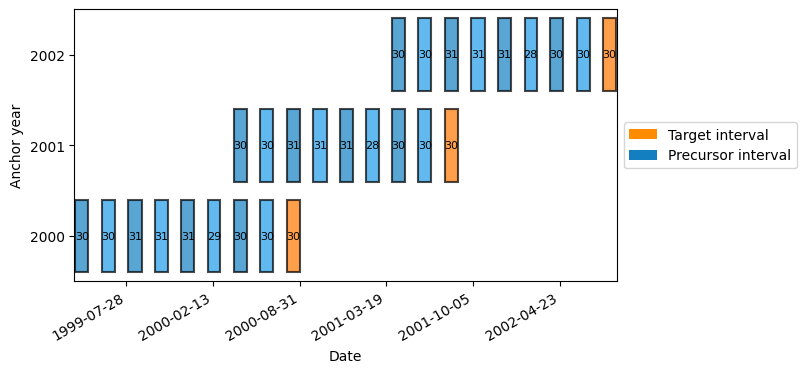

In [92]:
train_slice, test_slice = train_test_split(calendar, precursor_field)
target_train_slice, target_test_slice = train_test_split(calendar, target_field)
calendar.map_to_data(train_slice)
calendar.visualize(show_length=True)

In [93]:
test_slice

<xarray.DataArray 'sst' (time: 6575, latitude: 5, longitude: 13)> Size: 2MB
[427375 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 53kB 2003-01-01 2003-01-02 ... 2020-12-31
  * longitude  (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
Attributes:
    long_name:  Sea surface temperature
    units:      K

### 5 - Fit preprocessor with training samples and preprocess data

In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [94]:
from s2spy import preprocess
from s2spy import RGDR

# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(train_slice)

The temporal resolution of data does not completely match the target timescale. Please check your input data.


In [95]:
# select variables and intervals
train_prep = preprocessor.transform(train_slice)
precursor_field_resample = lilio.resample(calendar, train_prep)
target_field_resample = lilio.resample(calendar, target_train_slice)

In [96]:
rgdr = RGDR(
    target_intervals=1,
    lag=1,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0)

# Train model on all training data

rgdr.fit(precursor_field_resample, target_field_resample)

# transform to data
clusters = rgdr.transform(precursor_field_resample)

# Prepare test data
calendar.map_to_data(test_slice)
test_prep = preprocessor.transform(test_slice)
precursor_test_resample = lilio.resample(calendar, test_prep)
target_test_resample = lilio.resample(calendar, target_test_slice)

clusters_test = rgdr.transform(precursor_test_resample)

#### 6 - Load ONNX model

Now, that the data has been preprocessed and clustered. We can load the trained model from [pred_temperature_ridge.ipynb](pred_temperature_ridge.ipynb).

In [97]:
import onnxruntime as ort
# Load the ONNX model
model_path = 'model.onnx'
session = ort.InferenceSession(model_path)
pred_ort = session.run(None, {"X": clusters_test.isel(i_interval=0).values.astype(np.float32)})[0]

pred_ort

array([[295.24966],
       [296.19693],
       [295.97415],
       [296.27057],
       [295.411  ],
       [294.8868 ],
       [297.02994],
       [297.16443],
       [296.9564 ],
       [295.50986],
       [294.83182],
       [295.13818],
       [295.96295],
       [296.5652 ],
       [296.2868 ],
       [295.16876],
       [296.08533]], dtype=float32)

#### 7 - Run Dianna and interpret results

In [98]:
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

Choose data instances to run Dianna on and add names to the clusters. 

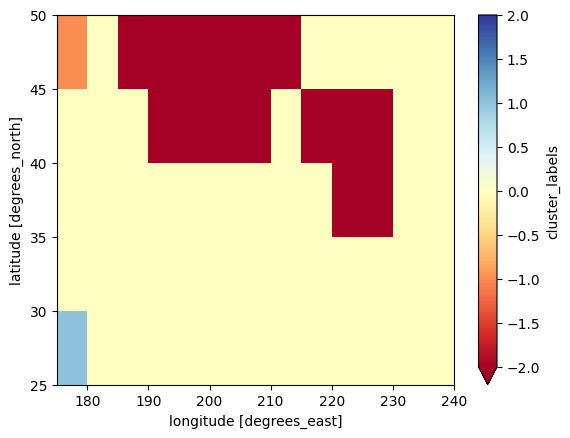

In [99]:
data_instance = clusters_test.isel(i_interval=0).to_numpy()

rgdr.cluster_map.plot(cmap='RdYlBu', vmin=-2, vmax=2)

In [100]:
df = pd.DataFrame(data_instance, columns =['A', 'B', 'C', 'D']) 
df

,A,B,C,D
0,0.849857,0.153417,0.028709,-1.200460
1,-0.217506,0.464255,0.011813,0.258590
2,-0.486289,0.355041,1.068336,-0.093562
3,0.005830,-0.559436,0.942054,0.612074
4,0.627864,0.357521,1.145939,-0.200125
5,1.051538,1.485329,1.025828,-0.403847
6,-1.169908,-0.202013,-0.083489,0.831314
7,-1.384062,0.611535,0.070696,1.585762
8,-0.833296,-0.169586,-0.164294,1.017969
9,1.027135,0.859617,0.440270,0.463961


Run Dianna to explain all data instances in the test dataset. 

In [101]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data = clusters.isel(i_interval=0).values.astype(np.float32), 
                                     training_data_kmeans = 5, feature_names=df.columns)

explanation

  0%|          | 0/17 [00:00<?, ?it/s]

array([[-3.84986514e-01, -4.03188070e-02, -1.53206719e-02,
        -4.46441529e-01],
       [ 9.92378356e-02, -1.18727306e-01, -1.14375523e-02,
         9.11251250e-02],
       [ 2.21169487e-01, -9.11798629e-02, -2.53947061e-01,
        -3.86227805e-02],
       [-2.07804120e-03,  1.39512743e-01, -2.24958571e-01,
         2.21360888e-01],
       [-2.84274449e-01, -9.18054127e-02, -2.71756187e-01,
        -7.78850374e-02],
       [-4.76478698e-01, -3.76311529e-01, -2.44188944e-01,
        -1.52942355e-01],
       [ 5.31294263e-01,  4.93465000e-02,  1.04334392e-02,
         3.02131713e-01],
       [ 6.28445822e-01, -1.55882336e-01, -2.49551440e-02,
         5.80088540e-01],
       [ 3.78594716e-01,  4.11683945e-02,  2.89876423e-02,
         3.70907799e-01],
       [-4.65405903e-01, -2.18469166e-01, -1.09786261e-01,
         1.66786678e-01],
       [-6.15834493e-01, -3.41064271e-01, -1.25565241e-01,
        -2.22450196e-01],
       [-1.01049042e+00, -1.57161410e-01, -1.93526253e-02,
      

Inspect the explanation for one data instance. Here we see that for 2004, that 2 clusters had a positive effect on temperature and 2 a negative effect. 

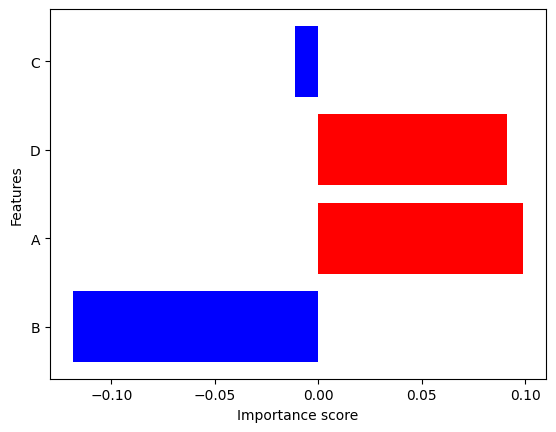

In [102]:
from dianna.visualization import plot_tabular

fig, _ = plot_tabular(explanation[1], df.columns, num_features=4)

We can also plot a summary of the impact of each cluster on the model output for all instances as well as a heatmap through time. 

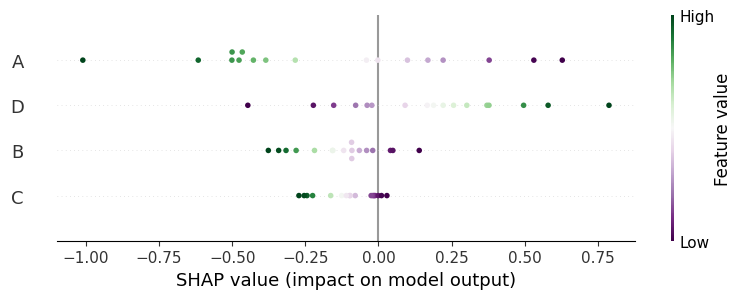

In [103]:
import shap
from shap import Explanation
import matplotlib.pyplot as plt


# create summary plot
shap.summary_plot(explanation, df.values, feature_names=df.columns, cmap="PRGn", show=False, max_display=15)
summary_img = plt.gcf()

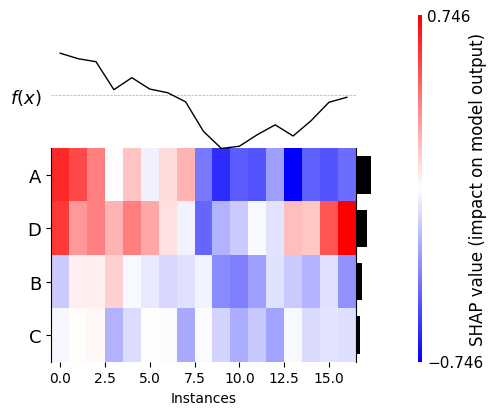

In [104]:
# create heatmap plot
shap_values = Explanation(explanation)
shap_values.feature_names = df.columns

shap.plots.heatmap(shap_values, cmap="bwr", show=False, max_display=15)
heatmap_img = plt.gcf()